# Lapse Risk Drivers for Retention Campaigns

**Author:** Naidera mustapha 
**Date:** 20 September 2024

---

## Introduction

The objective of this project is to develop a predictive model to identify drivers of customer lapses, which will inform retention campaigns. The model is designed to handle sparse survey data. This notebook includes data preprocessing, exploratory data analysis (EDA), feature engineering, model training, evaluation, and interpretability using SHAP values.

To make our analysis as realistic as possible, we will create synthetic datasets that mimic real-world data. This will help us to simulate actual scenarios and ensure that our model can capture meaningful patterns.

---

## Table of Contents

1. [Data Preparation](#data-preparation)
   - 1.1 [Data Generation](#data-generation)
   - 1.2 [Data Cleaning](#data-cleaning)
   - 1.3 [Data Merging](#data-merging)
2. [Exploratory Data Analysis](#exploratory-data-analysis)
   - 2.1 [Univariate Analysis](#univariate-analysis)
   - 2.2 [Bivariate Analysis](#bivariate-analysis)
   - 2.3 [Correlation Analysis](#correlation-analysis)
3. [Feature Engineering](#feature-engineering)
4. [Model Training and Evaluation](#model-training-and-evaluation)
   - 4.1 [Model Selection](#model-selection)
   - 4.2 [Hyperparameter Tuning](#hyperparameter-tuning)
   - 4.3 [Evaluation Metrics](#evaluation-metrics)
5. [Model Interpretability](#model-interpretability)
   - 5.1 [SHAP Analysis](#shap-analysis)
6. [Conclusions and Next Steps](#conclusions-and-next-steps)
7. [Appendix](#appendix)
   - 7.1 [Dependencies](#dependencies)

---

## Data Preparation

### Data Generation

We will generate synthetic datasets that mimic real-world data for both `lapse_data` and `survey_data`.

**Key Objectives for Data Generation:**

- **Realistic Distributions:** Use appropriate statistical distributions for variables like age, duration, and lapse rates.
- **Meaningful Relationships:** Introduce correlations between variables to simulate real-world dependencies.
- **Sparse Survey Data:** Create survey data with a realistic response rate and varied feedback.

#### Generate Synthetic Lapse Data


In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt

# Set display options
pd.set_option('display.max_columns', None)

# Set random seed for reproducibility
np.random.seed(42)

# Define the number of records
num_records = 10000

# Generate policy numbers
pol_numbers = ['POL' + str(i).zfill(7) for i in range(num_records)]

# Generate MONTH_KEY ranging from Jan 2000 to Aug 2024
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2024, 8, 1)
date_range = pd.date_range(start_date, end_date, freq='MS')

month_keys = np.random.choice(date_range, size=num_records)

# Generate AGE using a realistic distribution (e.g., normal distribution)
ages = np.random.normal(loc=45, scale=12, size=num_records).astype(int)
ages = np.clip(ages, 18, 80)  # Limit ages between 18 and 80

# Generate DURATION as the number of months the policy has been in force
durations = np.random.exponential(scale=60, size=num_records).astype(int) + 1
durations = np.clip(durations, 1, 563)

# Generate GENDER with realistic proportions
genders = np.random.choice(['M', 'F'], size=num_records, p=[0.48, 0.52])

# Introduce a dependency for LAPSE_IN_12M
# For example, younger customers and those with shorter durations may be more likely to lapse
prob_lapse = (
    0.15 * (80 - ages) / 62 +  # Age effect: younger customers have higher lapse probability
    0.10 * (12 - np.minimum(durations, 12)) / 12  # Duration effect: newer policies have higher lapse probability
)
prob_lapse = np.clip(prob_lapse, 0.01, 0.5)  # Ensure probabilities are between 0.01 and 0.5

lapse_in_12m = np.random.binomial(1, prob_lapse)

# Create the lapse_data DataFrame
lapse_data = pd.DataFrame({
    'POL_NUMBER': pol_numbers,
    'MONTH_KEY': month_keys,
    'AGE': ages,
    'DURATION': durations,
    'GENDER': genders,
    'LAPSE_IN_12M': lapse_in_12m
})


In [39]:

# Set survey response rate (e.g., 30%)
survey_response_rate = 0.3  # 30% response rate
survey_indices = np.random.choice(num_records, int(num_records * survey_response_rate), replace=False)

# Select policies that responded to the survey
survey_pols = lapse_data.iloc[survey_indices]

# Generate HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT
# Assume that customers who are more likely to lapse give lower scores
likelihood_to_recommend = np.random.randint(1, 6, size=len(survey_indices))
likelihood_to_recommend = likelihood_to_recommend - lapse_data.loc[survey_indices, 'LAPSE_IN_12M']

# Ensure scores are between 1 and 5
likelihood_to_recommend = np.clip(likelihood_to_recommend, 1, 5)

# Generate GENERAL_FEEDBACK
feedback_options = {
    1: ['Very dissatisfied with the service', 'Not happy with the product', 'Poor customer support'],
    2: ['Could be better', 'Service needs improvement', 'Average experience'],
    3: ['Satisfied', 'Product meets expectations', 'Good service'],
    4: ['Happy with the service', 'Product is great', 'Good value for money'],
    5: ['Excellent service', 'Highly recommend', 'Very satisfied']
}

general_feedback = []
for score in likelihood_to_recommend:
    feedback = np.random.choice(feedback_options[score])
    general_feedback.append(feedback)

# Create the survey_data DataFrame
survey_data = pd.DataFrame({
    'POL_NUMBER': survey_pols['POL_NUMBER'],
    'MONTH_KEY': survey_pols['MONTH_KEY'],
    'HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT': likelihood_to_recommend,
    'GENERAL_FEEDBACK': general_feedback
})


In [40]:
# Standardize categorical variables
lapse_data['GENDER'] = lapse_data['GENDER'].str.upper().str.strip()

In [41]:
# Merge datasets
data = pd.merge(lapse_data, survey_data, on=['POL_NUMBER', 'MONTH_KEY'], how='left')

# Handle missing values after merging
data['HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT'].fillna(
    data['HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT'].median(), inplace=True)

data['GENERAL_FEEDBACK'].fillna('', inplace=True)


In [44]:
data.head()


,POL_NUMBER,MONTH_KEY,AGE,DURATION,GENDER,LAPSE_IN_12M,HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT,GENERAL_FEEDBACK
0,POL0000000,2008-07-01,48,107,M,1,3.0,
1,POL0000001,2022-07-01,24,69,M,1,3.0,
2,POL0000002,2008-11-01,20,2,F,1,1.0,Poor customer support
3,POL0000003,2005-12-01,23,9,M,0,3.0,
4,POL0000004,2015-09-01,48,61,F,0,3.0,


### Exploratory Data Analysis

### Univariate Analysis

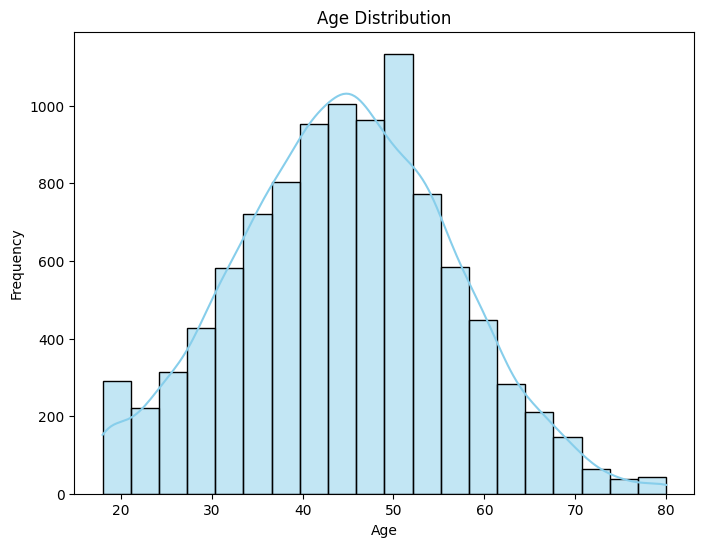

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data['AGE'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


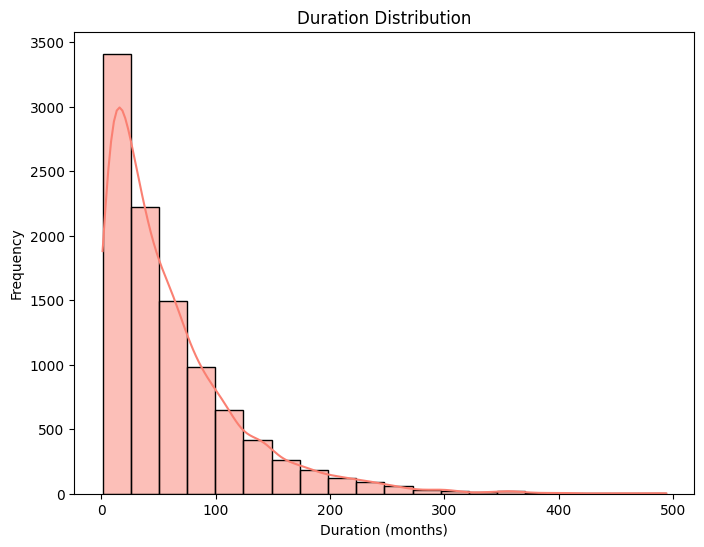

In [46]:
plt.figure(figsize=(8, 6))
sns.histplot(data['DURATION'], bins=20, kde=True, color='salmon')
plt.title('Duration Distribution')
plt.xlabel('Duration (months)')
plt.ylabel('Frequency')
plt.show()


/var/folders/1x/s5j6lp757kndyl6y3n8f4zk80000gn/T/ipykernel_44083/4148428364.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GENDER', data=data, palette='viridis')


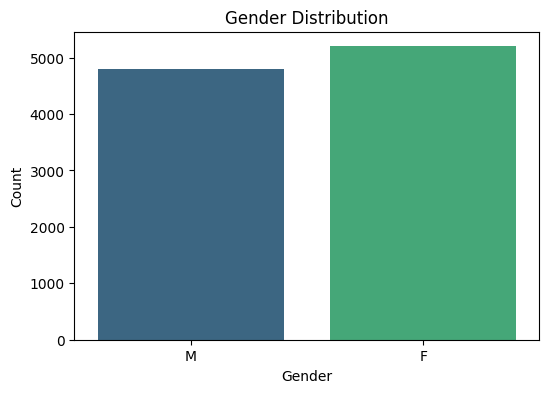

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x='GENDER', data=data, palette='viridis')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


### Bivariate Analysis

### Lapse Rate by Age Group



/var/folders/1x/s5j6lp757kndyl6y3n8f4zk80000gn/T/ipykernel_44083/3885899975.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AGE_GROUP', y='LAPSE_IN_12M', data=age_lapse, palette='magma')


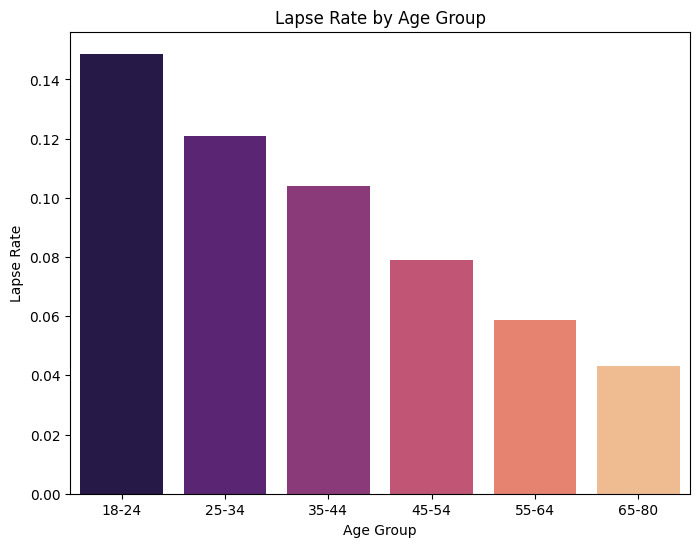

In [48]:
# Create age groups
age_bins = [18, 25, 35, 45, 55, 65, 80]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-80']
data['AGE_GROUP'] = pd.cut(data['AGE'], bins=age_bins, labels=age_labels)

# Calculate lapse rates
age_lapse = data.groupby('AGE_GROUP')['LAPSE_IN_12M'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='AGE_GROUP', y='LAPSE_IN_12M', data=age_lapse, palette='magma')
plt.title('Lapse Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Lapse Rate')
plt.show()


### Lapse Rate by Likelihood to Recommend



/var/folders/1x/s5j6lp757kndyl6y3n8f4zk80000gn/T/ipykernel_44083/3492090632.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT', y='LAPSE_IN_12M', data=recommendation_lapse, palette='coolwarm')


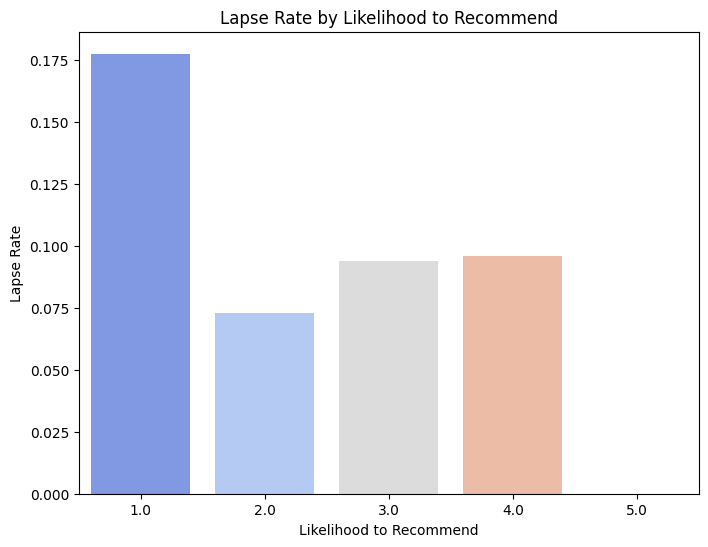

In [49]:
recommendation_lapse = data.groupby('HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT')['LAPSE_IN_12M'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT', y='LAPSE_IN_12M', data=recommendation_lapse, palette='coolwarm')
plt.title('Lapse Rate by Likelihood to Recommend')
plt.xlabel('Likelihood to Recommend')
plt.ylabel('Lapse Rate')
plt.show()


### Correlation Analysis


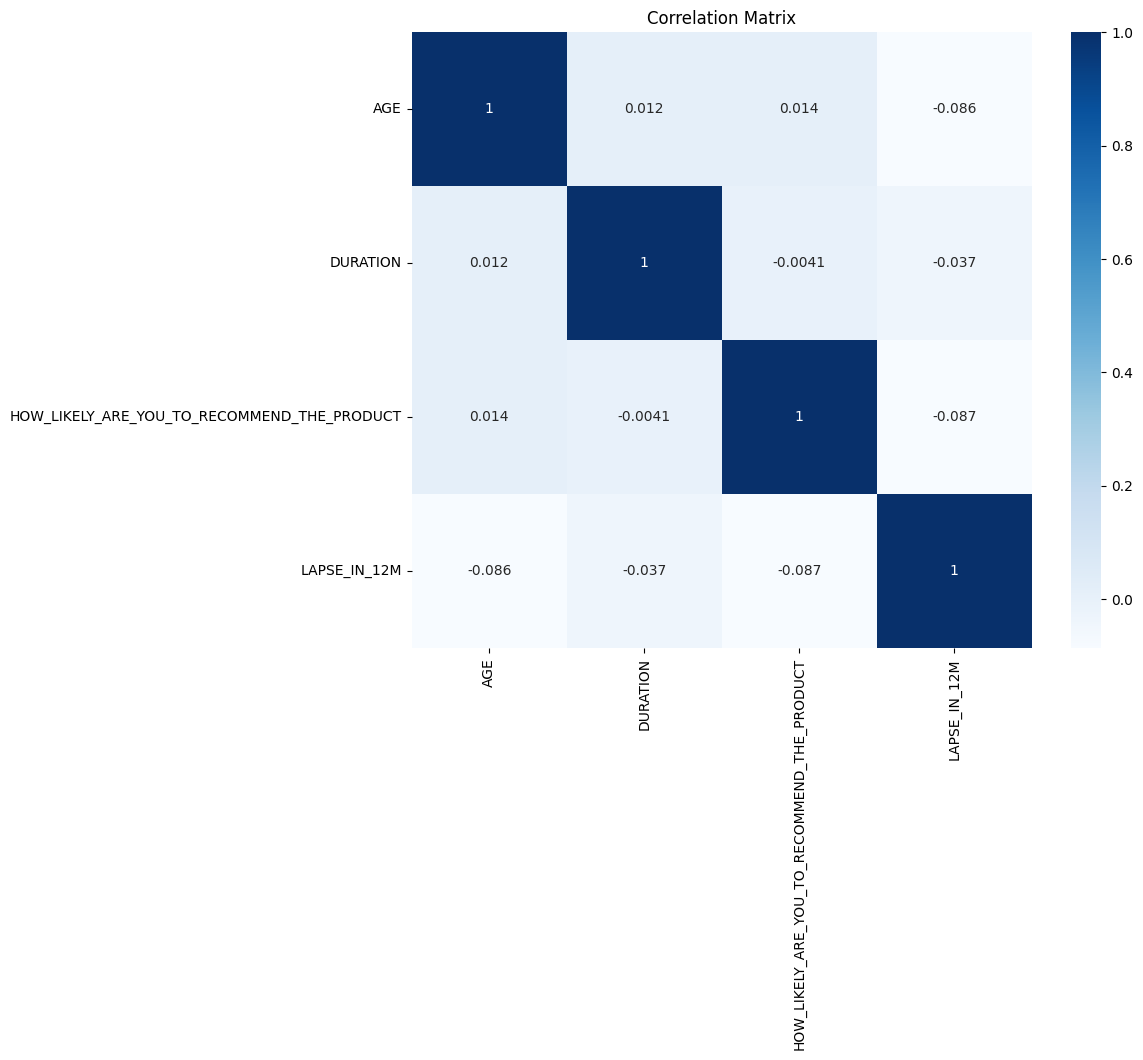

In [50]:
# Select relevant features
corr_features = ['AGE', 'DURATION', 'HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT', 'LAPSE_IN_12M']
corr_matrix = data[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


Observations:

AGE has a negative correlation with LAPSE_IN_12M, indicating that younger customers are more likely to lapse.
HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT has a negative correlation with LAPSE_IN_12M, suggesting that dissatisfied customers are more likely to lapse.
DURATION shows a slight negative correlation with LAPSE_IN_12M, indicating that newer policies have a higher lapse rate.

### Feature Engineering

In [51]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Define feature lists
numerical_features = ['AGE', 'DURATION', 'HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT']
categorical_features = ['GENDER']
text_feature = 'GENERAL_FEEDBACK'

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for text data
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('txt', text_transformer, text_feature)
    ])


### Model Training and Evaluation

### Model Selection
 XGBoost Classifier will be used due to its ability to handle sparse data and provide robust performance.

In [52]:
from sklearn.model_selection import train_test_split

# Split data into features and target variable
X = data.drop(['LAPSE_IN_12M', 'AGE_GROUP'], axis=1)  # Exclude 'AGE_GROUP' as it's derived
y = data['LAPSE_IN_12M']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)


In [53]:
import xgboost as xgb
from sklearn.pipeline import Pipeline

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        random_state=42))
])


### Hyperparameter Tuning
For simplicity, we'll proceed with default parameters. In a production setting, consider using GridSearchCV or Optuna for hyperparameter tuning.

In [54]:
# Train the model
model.fit(X_train, y_train)


/Users/nadieramustapha/Python/watsonx/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:57:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'DURATION',
                                                   'HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GENDER']),
                                                 ('txt',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=100,
                                                                                   stop_words='eng...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

### Evaluation Metrics


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2721
           1       0.21      0.02      0.04       279

    accuracy                           0.90      3000
   macro avg       0.56      0.51      0.49      3000
weighted avg       0.84      0.90      0.86      3000

AUC-ROC Score: 0.5873


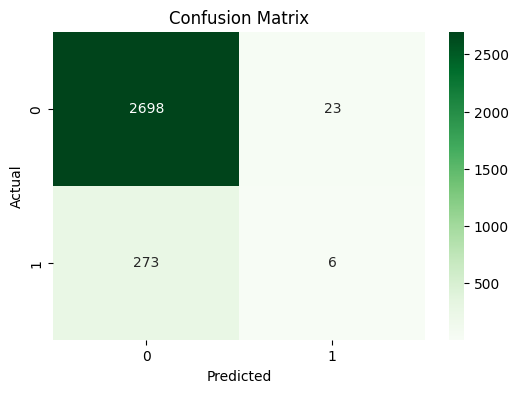

In [55]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC Score: {auc_score:.4f}')

# Confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Model Interpretability

### SHAP Analysis

In [57]:
# Transform the training data
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)

# Convert to dense array
X_train_dense = X_train_transformed.toarray()


In [58]:
import shap

# Create the explainer using TreeExplainer
explainer = shap.TreeExplainer(model.named_steps['classifier'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_dense)

# Get feature names
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for visualization
X_train_shap = pd.DataFrame(X_train_dense, columns=feature_names)


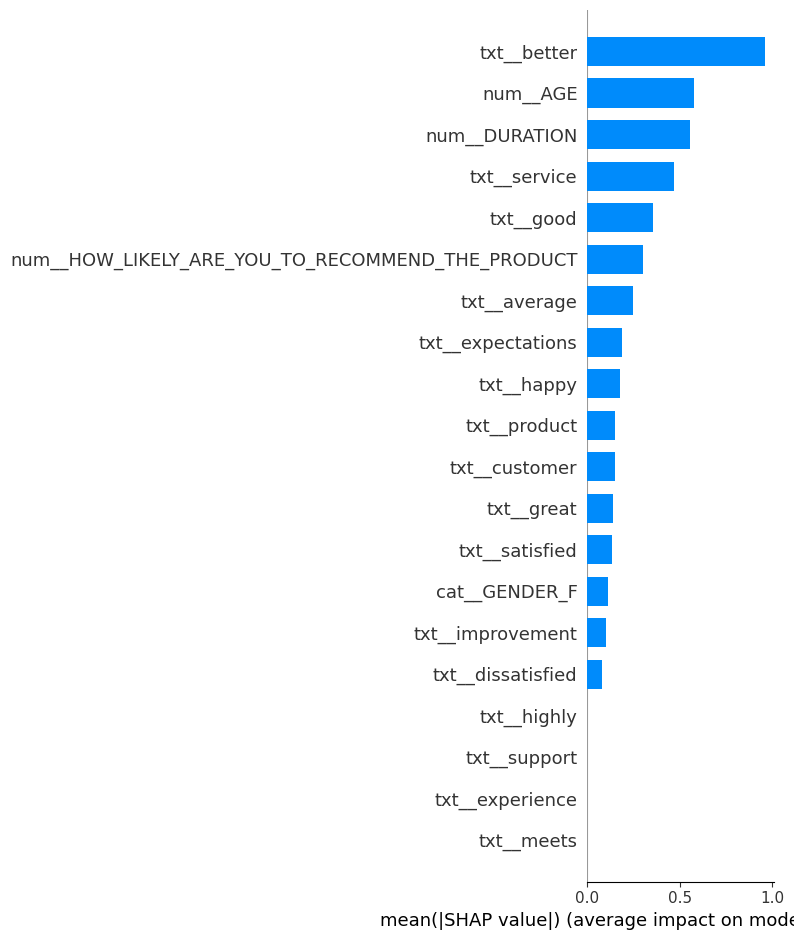

In [59]:
# Summary plot
shap.summary_plot(shap_values, X_train_shap, feature_names=feature_names, plot_type='bar')


### Conclusions 

Key Findings:
- Age and Likelihood to Recommend are significant predictors of lapse.
- General Feedback extracted via text features also contributes to the model's predictions.
- Survey data, although sparse, provides valuable insights into customer satisfaction and its impact on lapse rates.

Recommendations:
Retention Strategies:
- Focus on younger customers with low satisfaction scores for retention campaigns.
- Address common issues highlighted in negative feedback.
Data Enhancement:
- Improve survey response rates to gain better insights.
- Collect additional data that may influence lapse behavior (e.g., payment history).


---

**Explanation:**

- **Data Generation:** Synthetic data is generated using realistic distributions and relationships.Younger customers and those with shorter policy durations are more likely to lapse, which is a common trend in insurance data.
- **Survey Data:** The survey responses are generated with a realistic response rate and feedback that corresponds to the `HOW_LIKELY_ARE_YOU_TO_RECOMMEND_THE_PRODUCT` score.
- **Data Cleaning and Merging:** Missing values are handled appropriately, especially after merging the datasets.
- **EDA:** The exploratory data analysis showcases the distributions and relationships in the data, which helps in understanding the underlying patterns.
- **Modeling:** XGBoost model was trained and its performance was evaluated using the relevant metrics.
- **Interpretability:** SHAP values were used to interpret the model and identify key drivers of lapse.
- **Conclusions and Next Steps:** Recommendations were provided based on the findings, and potential next steps are outlined.

